# Tutorial: SCENIC+ step-by-step in the human cerebellum

In [1]:
%matplotlib inline
import scenicplus
scenicplus.__version__

'0.1.dev373+geb5f14e'

In this tutorial we describe the minimum steps to generate a SCENIC+ object and build e-GRNs. For more details on how the data was processed with pycisTopic and pycistarget, check the human cerebellum tutorials available at https://pycistopic.readthedocs.io/ and https://pycistarget.readthedocs.io/, respectively.

Data used in the tutorial is freely accessible at: https://www.10xgenomics.com/resources/datasets/frozen-human-healthy-brain-tissue-3-k-1-standard-1-0-0

Processed loom files are available at: https://scope.aertslab.org/#/scenic-v2

A UCSC session is available at: https://genome-euro.ucsc.edu/s/cbravo/SCENIC%2B_cerebellum

## 1. Create SCENIC+ object 

For generating a SCENIC+ you will require:

* scRNA-seq annData object (e.g. scanpy)
* scATAC-seq cisTopic object
* Pycistarget motif enrichment dictionary

In [1]:
# Load functions
from scenicplus.scenicplus_class import SCENICPLUS, create_SCENICPLUS_object
from scenicplus.preprocessing.filtering import *

First we will load the scRNA-seq and the scATAC-seq data. We make sure that names match between them.

In [2]:
# Load data
## ATAC - cisTopic object
import pickle
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/atac/pycistopic/10x_multiome_brain_cisTopicObject_noDBL.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()
## Precomputed imputed data
import pickle
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/atac/pycistopic/DARs/Imputed_accessibility.pkl', 'rb') 
imputed_acc_obj = pickle.load(infile)
infile.close()
## RNA - Create Anndata
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
import itertools
import anndata
path_to_loom = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/rna/seurat/10x_multiome_brain_Seurat.loom'
loom = SCopeLoom.read_loom(path_to_loom)
metadata = get_metadata(loom)
# Fix names
metadata['barcode'] = [x.split('-')[0] for x in metadata.index.tolist()]
metadata['barcode'] = metadata['barcode'] + '-1'
metadata.index = metadata['barcode'] + '-10x_multiome_brain'
expr_mat = loom.ex_mtx
expr_mat.index = metadata['barcode'] + '-10x_multiome_brain'
rna_anndata = anndata.AnnData(X=expr_mat)
rna_anndata.obs = metadata

If you have generated your cisTopic object with an old version of pycisTopic, it is possible that your region data was affected by a previous bug. You can fix it with the code below:

In [3]:
# Fix region data (bug in old pycistopic versions)
from pycisTopic.utils import region_names_to_coordinates
fragment_matrix = cistopic_obj.fragment_matrix
binary_matrix = cistopic_obj.binary_matrix
region_data = region_names_to_coordinates(cistopic_obj.region_names)
region_data['Width'] = abs(region_data.End -region_data.Start).astype(np.int32)
region_data['cisTopic_nr_frag'] = np.array(
fragment_matrix.sum(axis=1)).flatten()
region_data['cisTopic_log_nr_frag'] = np.log10(
region_data['cisTopic_nr_frag'])
region_data['cisTopic_nr_acc'] = np.array(
binary_matrix.sum(axis=1)).flatten()
region_data['cisTopic_log_nr_acc'] = np.log10(
region_data['cisTopic_nr_acc'])
cistopic_obj.region_data = region_data

Next we load the motif enrichment results into a dictionary. We can load motif results from the different methods in pycistarget (e.g. cisTarget, DEM) and different region sets (e.g. topics, DARs, MACS bdgdiff peaks). In this tutorial we will use both cisTarget and DEM peaks from topics and DARs. Note that if you have used the pycistarget wrapper function, the dictionary in menr.pkl can be directly pass as `menr` in the `create_SCENICPLUS_object` function.

In [4]:
# Load cistarget and DEM motif enrichment results
motif_enrichment_dict={}
import pickle
from pycistarget.motif_enrichment_dem import *
path = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/atac/pycistarget/'
infile = open(path +'topics/topic_cistarget_dict.pkl', 'rb')
motif_enrichment_dict['CTX_Topics_All'] = pickle.load(infile)
infile.close()
infile = open(path +'topics/topic_DEM_dict.pkl', 'rb')
motif_enrichment_dict['DEM_Topics_All'] = pickle.load(infile)
infile.close()
infile = open(path +'DARs/DARs_cistarget_dict.pkl', 'rb')
motif_enrichment_dict['CTX_DARs_All'] = pickle.load(infile)
infile.close()
infile = open(path +'DARs/DARs_DEM_dict.pkl', 'rb')
motif_enrichment_dict['DEM_DARs_All'] = pickle.load(infile)
infile.close()

Now we can create the SCENIC+ object:

In [5]:
scplus_obj = create_SCENICPLUS_object(
        GEX_anndata = rna_anndata,
        cisTopic_obj = cistopic_obj,
        imputed_acc_obj = imputed_acc_obj,
        menr = motif_enrichment_dict,
        ACC_prefix = 'ACC_',
        GEX_prefix = 'GEX_',
        bc_transform_func = lambda x: x,
        normalize_imputed_acc = False)

In [6]:
print(scplus_obj)

SCENIC+ object with n_cells x n_genes = 1736 x 26399 and n_cells x n_regions = 1736 x 422146
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_cell:'GEX_VSN_cell_type', 'GEX_VSN_leiden_res0.3', 'GEX_VSN_leiden_res0.6', 'GEX_VSN_leiden_res0.9', 'GEX_VSN_leiden_res1.2', 'GEX_VSN_sample_id', 'GEX_Seurat_leiden_res0.6', 'GEX_Seurat_leiden_res1.2', 'GEX_Seurat_cell_type', 'GEX_barcode', 'ACC_cisTopic_nr_frag', 'ACC_cisTopic_log_nr_acc', 'ACC_barcode', 'ACC_VSN_leiden_res0.6', 'ACC_FRIP', 'ACC_TSS_enrichment', 'ACC_cisTopic_nr_acc', 'ACC_VSN_leiden_res0.9', 'ACC_VSN_RNA+ATAC_leiden_100_2', 'ACC_Dupl_rate', 'ACC_sample_id', 'ACC_pycisTopic_leiden_10_0.6', 'ACC_pycisTopic_leiden_10_1.2', 'ACC_Seurat_leiden_res0.6', 'ACC_Total_nr_frag', 'ACC_Total_nr_frag_in_regions', 'ACC_VSN_leiden_res1.2', 'ACC_VSN_cell_type', 'ACC_Unique_nr_frag_in_regions', 'ACC_Seurat_cell_type', 'ACC_Predicted_doublets_f

You can also filter low accessible regions and low expressed genes. This recommended to avoid getting false relationships with these regions and genes.

In [7]:
filter_genes(scplus_obj, min_pct = 0.5)
filter_regions(scplus_obj, min_pct = 0.5)

2022-01-04 17:24:16,750 Preprocessing INFO     Going from 26399 genes to 20448 genes.
2022-01-04 17:24:50,192 Preprocessing INFO     Going from 422146 regions to 375805 regions.


## 2. Generate cistromes

The next step is to generate cistromes. By default, all targets assigned to a TF across the motif enrichment dictionaries will be taken, and overlapped with regions in the SCENIC+ object. However, it is possible to also subset for regions accessible in certain cell type as well, to generate cell type specific cistromes. This approach is described in the tutorial `cistrome_pruning_advanced.ipynb`.

In [8]:
# Merge cistromes (all)
from scenicplus.cistromes import *
import time
start_time = time.time()
merge_cistromes(scplus_obj)
time = time.time()-start_time
print(time/60)

7.251678760846456


## 3. Infer enhancer to gene relationships

To infer enhancer-to-gene relationships, we exploit correlation between region accessibility and gene expression. In addition, to assess no non-linear relationships, we also use Gradient Boosting Machines. More details on these steps can be found in the tutorial `r2g_advanced.ipynb`.

### A. Get search space

We first need to define the search space around the gene. Here we will use 150kb upstream/downtream the gene, but TAD boundaries can be also used. **WARNING**: Make sure that the specified biomart_host matches your genome assembly. 

In [29]:
import pickle
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'rb')
scplus_obj = pickle.load(infile)
infile.close()

In [30]:
from scenicplus.enhancer_to_gene import get_search_space, calculate_regions_to_genes_relationships, GBM_KWARGS
get_search_space(scplus_obj,
                 biomart_host = 'http://www.ensembl.org',
                 species = 'hsapiens',
                 assembly = 'hg38', 
                 upstream = [1000, 150000],
                 downstream = [1000, 150000])

2022-01-04 17:50:07,795 R2G          INFO     Downloading gene annotation from biomart dataset: hsapiens_gene_ensembl


/opt/venv/lib/python3.8/site-packages/scenicplus/enhancer_to_gene.py:197: DtypeWarning:

Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.



2022-01-04 17:50:40,505 R2G          INFO     Downloading chromosome sizes from: http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes
2022-01-04 17:50:42,099 R2G          INFO     Extending promoter annotation to 10 bp upstream and 10 downstream
2022-01-04 17:50:44,632 R2G          INFO     Extending search space to:
            						150000 bp downstream of the end of the gene.
            						150000 bp upstream of the start of the gene.
2022-01-04 17:51:07,232 R2G          INFO     Intersecting with regions.


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


2022-01-04 17:51:08,592 R2G          INFO     Calculating distances from region to gene
2022-01-04 17:55:43,084 R2G          INFO     Imploding multiple entries per region and gene
2022-01-04 17:58:01,862 R2G          INFO     Done!


### B. Enhancer-to-gene models

Enhancer-to-gene models can be done using correlation, random forest (RF) or Gradient Boosting Machines (GBM). GBMs are a much faster alternative to RFs.

In [31]:
calculate_regions_to_genes_relationships(scplus_obj, 
                    ray_n_cpu = 20, 
                    _temp_dir = '/scratch/leuven/313/vsc31305/ray_spill',
                    importance_scoring_method = 'GBM',
                    importance_scoring_kwargs = GBM_KWARGS)

2022-01-04 17:59:17,845 R2G          INFO     Calculating region to gene importances, using GBM method


2022-01-04 17:59:30,930	INFO services.py:1338 -- View the Ray dashboard at http://127.0.0.1:8267
initializing:  22%|██▏       | 3225/14548 [04:27<15:17, 12.33it/s]

(score_regions_to_single_gene_ray pid=34847) 


initializing:  27%|██▋       | 3905/14548 [05:23<14:24, 12.30it/s]

(score_regions_to_single_gene_ray pid=34848) 


initializing:  27%|██▋       | 3953/14548 [05:27<14:34, 12.11it/s]

(score_regions_to_single_gene_ray pid=34840) 


initializing:  68%|██████▊   | 9874/14548 [13:49<06:23, 12.20it/s]

(score_regions_to_single_gene_ray pid=34855) 


Running using 20 cores: 100%|██████████| 14548/14548 [00:35<00:00, 408.74it/s] 


2022-01-04 18:20:38,987 R2G          INFO     Took 1281.1407558918 seconds
2022-01-04 18:20:38,990 R2G          INFO     Calculating region to gene correlation, using SR method


2022-01-04 18:20:53,862	INFO services.py:1338 -- View the Ray dashboard at http://127.0.0.1:8267
Running using 20 cores: 100%|██████████| 14548/14548 [00:50<00:00, 288.45it/s]


2022-01-04 18:41:13,309 R2G          INFO     Took 1234.3179178237915 seconds
2022-01-04 18:41:26,108 R2G          INFO     Done!


In [32]:
# Save
import pickle
with open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'wb') as f:
  pickle.dump(scplus_obj, f)

## 4. Infer TF to gene relationships

The next step is to infer relationships between TFs and target genes based on expression. We will use similar approaches as for the enhancer-to-gene relationships (GBM/RF and correlation). 

In [33]:
import pickle
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'rb')
scplus_obj = pickle.load(infile)
infile.close()

In [ ]:
from scenicplus.TF_to_gene import *
tf_file = '/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_hg38.txt'
calculate_TFs_to_genes_relationships(scplus_obj, 
                    tf_file = tf_file,
                    ray_n_cpu = 20, 
                    method = 'GBM',
                    _temp_dir = '/scratch/leuven/313/vsc31305/ray_spill',
                    key= 'TF2G_adj')

In [ ]:
# Save
import pickle
with open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'wb') as f:
  pickle.dump(scplus_obj, f)

If you have run SCENIC before in the gene expression matrix, it is possible to directly load adjancencies from that pipeline:

In [ ]:
load_TF2G_adj_from_file(scplus_obj, 
                        f_adj = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/rna/vsn/single_sample_scenic_HQ/out/scenic/10x_multiome_brain_HQ/arboreto_with_multiprocessing/10x_multiome_brain_HQ__adj.tsv', 
                        inplace = True, 
                        key= 'TF2G_adj')

## 5. Build eGRNs

The last step is to build the eGRNs using a recovery approach (GSEA). The ranking to use will be based on the TF-2-gene importances, while gene sets will be derived with different thresholding methods on the enhancer-to-gene relationships and the unfiltered cistromes.

In [1]:
import pickle
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'rb')
scplus_obj = pickle.load(infile)
infile.close()

In [ ]:
# Load functions
from scenicplus.grn_builder.gsea_approach import build_grn

build_grn(scplus_obj,
         min_target_genes = 10,
         adj_pval_thr = 1,
         min_regions_per_gene = 0,
         quantiles = (0.85, 0.90, 0.95),
         top_n_regionTogenes_per_gene = (5, 10, 15),
         top_n_regionTogenes_per_region = (),
         binarize_using_basc = True,
         rho_dichotomize_tf2g = True,
         rho_dichotomize_r2g = True,
         rho_dichotomize_eregulon = True,
         rho_threshold = 0.05,
         keep_extended_motif_annot = True,
         merge_eRegulons = True, 
         order_regions_to_genes_by = 'importance',
         order_TFs_to_genes_by = 'importance',
         key_added = 'eRegulons_importance',
         cistromes_key = 'Unfiltered',
         disable_tqdm = False, #If running in notebook, set to True
         ray_n_cpu = 20,
         _temp_dir = '/scratch/leuven/313/vsc31305/ray_spill')

To access the eGRNs:

In [ ]:
import dill
with open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'wb') as f:
  dill.dump(scplus_obj, f)

## 6. Exploring SCENIC+ results

### A. Generate eRegulon metadata

As a first step, we will format the eGRN metadata. This will integrate the results from the inference of enhancer-to-gene and TF-to-gene relationships and the eRegulon construction in one pandas dataframe that can be used for further exploration.

In [1]:
import dill
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'rb')
scplus_obj = dill.load(infile)
infile.close()

In [ ]:
from scenicplus.utils import format_egrns
format_egrns(scplus_obj, eregulons_key = 'eRegulons_importance', TF2G_key = 'TF2G_adj', key_added = 'eRegulon_metadata')

The eRegulon metadata will look as:

In [4]:
scplus_obj.uns['eRegulon_metadata'][0:10]

Region_signature_name Gene_signature_name    TF is_extended  \
0        ACO1_+_+_(24r)      ACO1_+_+_(23g)  ACO1       False   
1        ACO1_+_+_(24r)      ACO1_+_+_(23g)  ACO1       False   
2        ACO1_+_+_(24r)      ACO1_+_+_(23g)  ACO1       False   
3        ACO1_+_+_(24r)      ACO1_+_+_(23g)  ACO1       False   
4        ACO1_+_+_(24r)      ACO1_+_+_(23g)  ACO1       False   
5        ACO1_+_+_(24r)      ACO1_+_+_(23g)  ACO1       False   
6        ACO1_+_+_(24r)      ACO1_+_+_(23g)  ACO1       False   
7        ACO1_+_+_(24r)      ACO1_+_+_(23g)  ACO1       False   
8        ACO1_+_+_(24r)      ACO1_+_+_(23g)  ACO1       False   
9        ACO1_+_+_(24r)      ACO1_+_+_(23g)  ACO1       False   

                      Region      Gene  R2G_importance   R2G_rho  \
0   chr1:244918651-244919151    HNRNPU        0.021839  0.085878   
1    chr10:88991114-88991614       FAS        0.023378  0.215477   
2    chr10:88990599-88991099       FAS        0.031784  0.212687   
3   chrX:107676906-107677406      MID2        0.021056  0.098110   
4      chr16:1556214-1556714    IFT140        0.015752  0.098841   
5  chr10:103692953-103693453  SH3PXD2A        0.004005  0.146456   
6    chr19:57527137-57527637    ZNF549        0.078793  0.083988   
7    chr22:36323698-36324198      TXN2        0.020686  0.073909   
8     chr6:15365250-15365750    JARID2        0.025076  0.174829   
9  chr10:126525383-126525883    ADAM12        0.027865  0.067947   

   R2G_importance_x_rho  R2G_importance_x_abs_rho  TF2G_importance  \
0              0.001876                  0.001876         0.236510   
1              0.005037                  0.005037         0.457794   
2              0.006760                  0.006760         0.457794   
3              0.002066                  0.002066         0.663257   
4              0.001557                  0.001557         0.336581   
5              0.000587                  0.000587         4.731638   
6              0.006618                  0.006618         0.522762   
7              0.001529                  0.001529         1.298719   
8              0.004384                  0.004384         0.678238   
9              0.001893                  0.001893         0.233867   

   TF2G_regulation  TF2G_rho  TF2G_importance_x_abs_rho  TF2G_importance_x_rho  
0                1  0.122128                   0.028884               0.028884  
1                1  0.162854                   0.074554               0.074554  
2                1  0.162854                   0.074554               0.074554  
3                1  0.165609                   0.109842               0.109842  
4                1  0.095788                   0.032240               0.032240  
5                1  0.200345                   0.947960               0.947960  
6                1  0.154494                   0.080764               0.080764  
7                1  0.160698                   0.208702               0.208702  
8                1  0.231925                   0.157300               0.157300  
9                1  0.090295                   0.021117               0.021117

The first sign in the eRegulon name indicates the relationship between TF and gene; while the second indicates the relationship between region and gene. Additional columns can be added by the user, for example the enrichment of the TF motif in the regions.

### B. Assesing eGRN enrichment in cells

Next, we can score the eRegulons in the cells to assess how enriched target regions and target genes are enriched in each cell. We will score the region-based regulons on the scATAC-seq layer, while gene-based eRegulons will be scored using the transcriptome layer.

In [40]:
# Format eRegulons
from scenicplus.eregulon_enrichment import *
get_eRegulons_as_signatures(scplus_obj, eRegulon_metadata_key='eRegulon_metadata', key_added='eRegulon_signatures')

In [6]:
## Score chromatin layer
# Region based raking
from scenicplus.cistromes import *
import time
start_time = time.time()
region_ranking = make_rankings(scplus_obj, target='region')
# Score region regulons
score_eRegulons(scplus_obj,
                ranking = region_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures',
                key_added = 'eRegulon_AUC', 
                enrichment_type= 'region',
                auc_threshold = 0.05,
                normalize = False,
                n_cpu = 1)
time = time.time()-start_time
print(time/60)

100%|██████████| 832/832 [00:26<00:00, 31.16it/s]


2.8363844593365988


In [7]:
## Score transcriptome layer
# Gene based raking
from scenicplus.cistromes import *
import time
start_time = time.time()
gene_ranking = make_rankings(scplus_obj, target='gene')
# Score gene regulons
score_eRegulons(scplus_obj,
                gene_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures',
                key_added = 'eRegulon_AUC', 
                enrichment_type = 'gene',
                auc_threshold = 0.05,
                normalize= False,
                n_cpu = 1)
time = time.time()-start_time
print(time/60)

100%|██████████| 832/832 [00:07<00:00, 104.80it/s]


0.21863729159037273


### C. Assessing TF-eGRN relationships

Next we can assess the relationship between the TF expression and the eRegulons; in other words, whether genes expressed/repressed and regions accessible/closed when the TF is present. Due to the amount of drop-outs, and the variability in cell types proportions, using directly the AUC cistrome matrix can result in noisy correlations. Here, we use pseudobulks, in which we sample a number of cells per cell type. In this example, we merge 5 cells per pseudobulk and generate 100 pseudobulks per cell type.

In [8]:
# Generate pseudobulks
import time
start_time = time.time()
generate_pseudobulks(scplus_obj, 
                         variable = 'ACC_Seurat_cell_type',
                         auc_key = 'eRegulon_AUC',
                         signature_key = 'Gene_based',
                         nr_cells = 5,
                         nr_pseudobulks = 100,
                         seed=555)
generate_pseudobulks(scplus_obj, 
                         variable = 'ACC_Seurat_cell_type',
                         auc_key = 'eRegulon_AUC',
                         signature_key = 'Region_based',
                         nr_cells = 5,
                         nr_pseudobulks = 100,
                         seed=555)
time = time.time()-start_time
print(time/60)

1.9503313183784485


In [9]:
# Correlation between TF and eRegulons
import time
start_time = time.time()
TF_cistrome_correlation(scplus_obj,
                        variable = 'ACC_Seurat_cell_type', 
                        auc_key = 'eRegulon_AUC',
                        signature_key = 'Gene_based',
                        out_key = 'ACC_Seurat_cell_type_eGRN_gene_based')
TF_cistrome_correlation(scplus_obj,
                        variable = 'ACC_Seurat_cell_type', 
                        auc_key = 'eRegulon_AUC',
                        signature_key = 'Region_based',
                        out_key = 'ACC_Seurat_cell_type_eGRN_region_based')
time = time.time()-start_time
print(time/60)

0.032043548425038655


We can plot eRegulon enrichment versus TF expression for each pseudobulk.

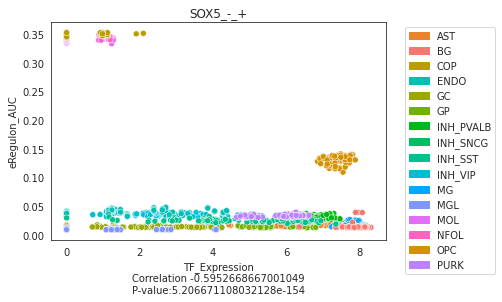

In [11]:
# Region based
%matplotlib inline
import seaborn as sns
sns.set_style("white")
colors = ["#E9842C","#F8766D", "#BC9D00", "#00C0B4", "#9CA700", "#6FB000", "#00B813", "#00BD61", "#00C08E", "#00BDD4",
           "#00A7FF", "#7F96FF", "#E26EF7", "#FF62BF", "#D69100", "#BC81FF"]
categories = sorted(set(scplus_obj.metadata_cell['ACC_Seurat_cell_type']))
color_dict = dict(zip(categories, colors[0:len(categories)]))
prune_plot(scplus_obj,
           'SOX5_-_+',
           pseudobulk_variable = 'ACC_Seurat_cell_type',
           show_dot_plot = True,
           show_line_plot = False,
           color_dict = color_dict,
           use_pseudobulk = True,
           auc_key = 'eRegulon_AUC',
           signature_key = 'Region_based',
           seed=555)

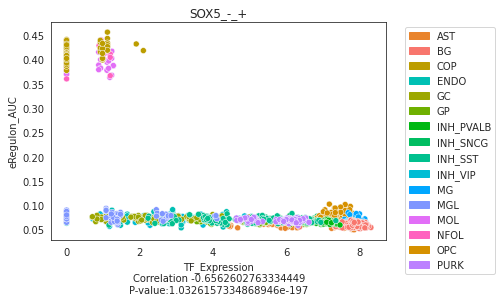

In [12]:
# Gene based
%matplotlib inline
sns.set_style("white")
colors = ["#E9842C","#F8766D", "#BC9D00", "#00C0B4", "#9CA700", "#6FB000", "#00B813", "#00BD61", "#00C08E", "#00BDD4",
           "#00A7FF", "#7F96FF", "#E26EF7", "#FF62BF", "#D69100", "#BC81FF"]
categories = sorted(set(scplus_obj.metadata_cell['ACC_Seurat_cell_type']))
color_dict = dict(zip(categories, colors[0:len(categories)]))
prune_plot(scplus_obj,
           'SOX5_-_+',
           pseudobulk_variable = 'ACC_Seurat_cell_type',
           show_dot_plot = True,
           show_line_plot = False,
           color_dict = color_dict,
           use_pseudobulk = True,
           auc_key = 'eRegulon_AUC',
           signature_key = 'Gene_based',
           seed=555)

### D. Identification of high quality regulons

We will select a subset of regulons based on the correlation between the region based and the gene based regulons. We will only use the extended eRegulon if there is not a direct eRegulon available.

In [46]:
# Correlation between region based regulons and gene based regulons
import pandas
df1 = scplus_obj.uns['eRegulon_AUC']['Gene_based'].copy()
df2 = scplus_obj.uns['eRegulon_AUC']['Region_based'].copy()
df1.columns = [x.split('_(')[0] for x in df1.columns]
df2.columns = [x.split('_(')[0] for x in df2.columns]
correlations = df1.corrwith(df2, axis = 0)
correlations = correlations[abs(correlations) > 0.6]
# Kepp only R2G +
keep = [x for x in correlations.index if '+_+' in x] + [x for x in correlations.index if '-_+' in x] 
# Keep extended if not direct
extended = [x for x in keep if 'extended' in x]
direct = [x for x in keep if not 'extended' in x]
keep_extended = [x for x in extended if not x.replace('extended_', '') in direct]
keep = direct + keep_extended
# Keep regulons with more than 10 genes
keep_gene = [x for x in scplus_obj.uns['eRegulon_AUC']['Gene_based'].columns if x.split('_(')[0] in keep]
keep_gene = [x for x in keep_gene if (int(x.split('_(')[1].replace('g)', '')) > 10)]
keep_all = [x.split('_(')[0] for x in keep_gene]
keep_region = [x for x in scplus_obj.uns['eRegulon_AUC']['Region_based'].columns if x.split('_(')[0] in keep]
scplus_obj.uns['selected_eRegulons'] = {}
scplus_obj.uns['selected_eRegulons']['Gene_based'] = keep_gene
scplus_obj.uns['selected_eRegulons']['Region_based'] = keep_region

In [47]:
len(keep_gene)

114

### E. Overlap between eRegulons

In addition, to assess which eRegulons tend to be enriched in the same group of cells we can generate a correlation plot as well.

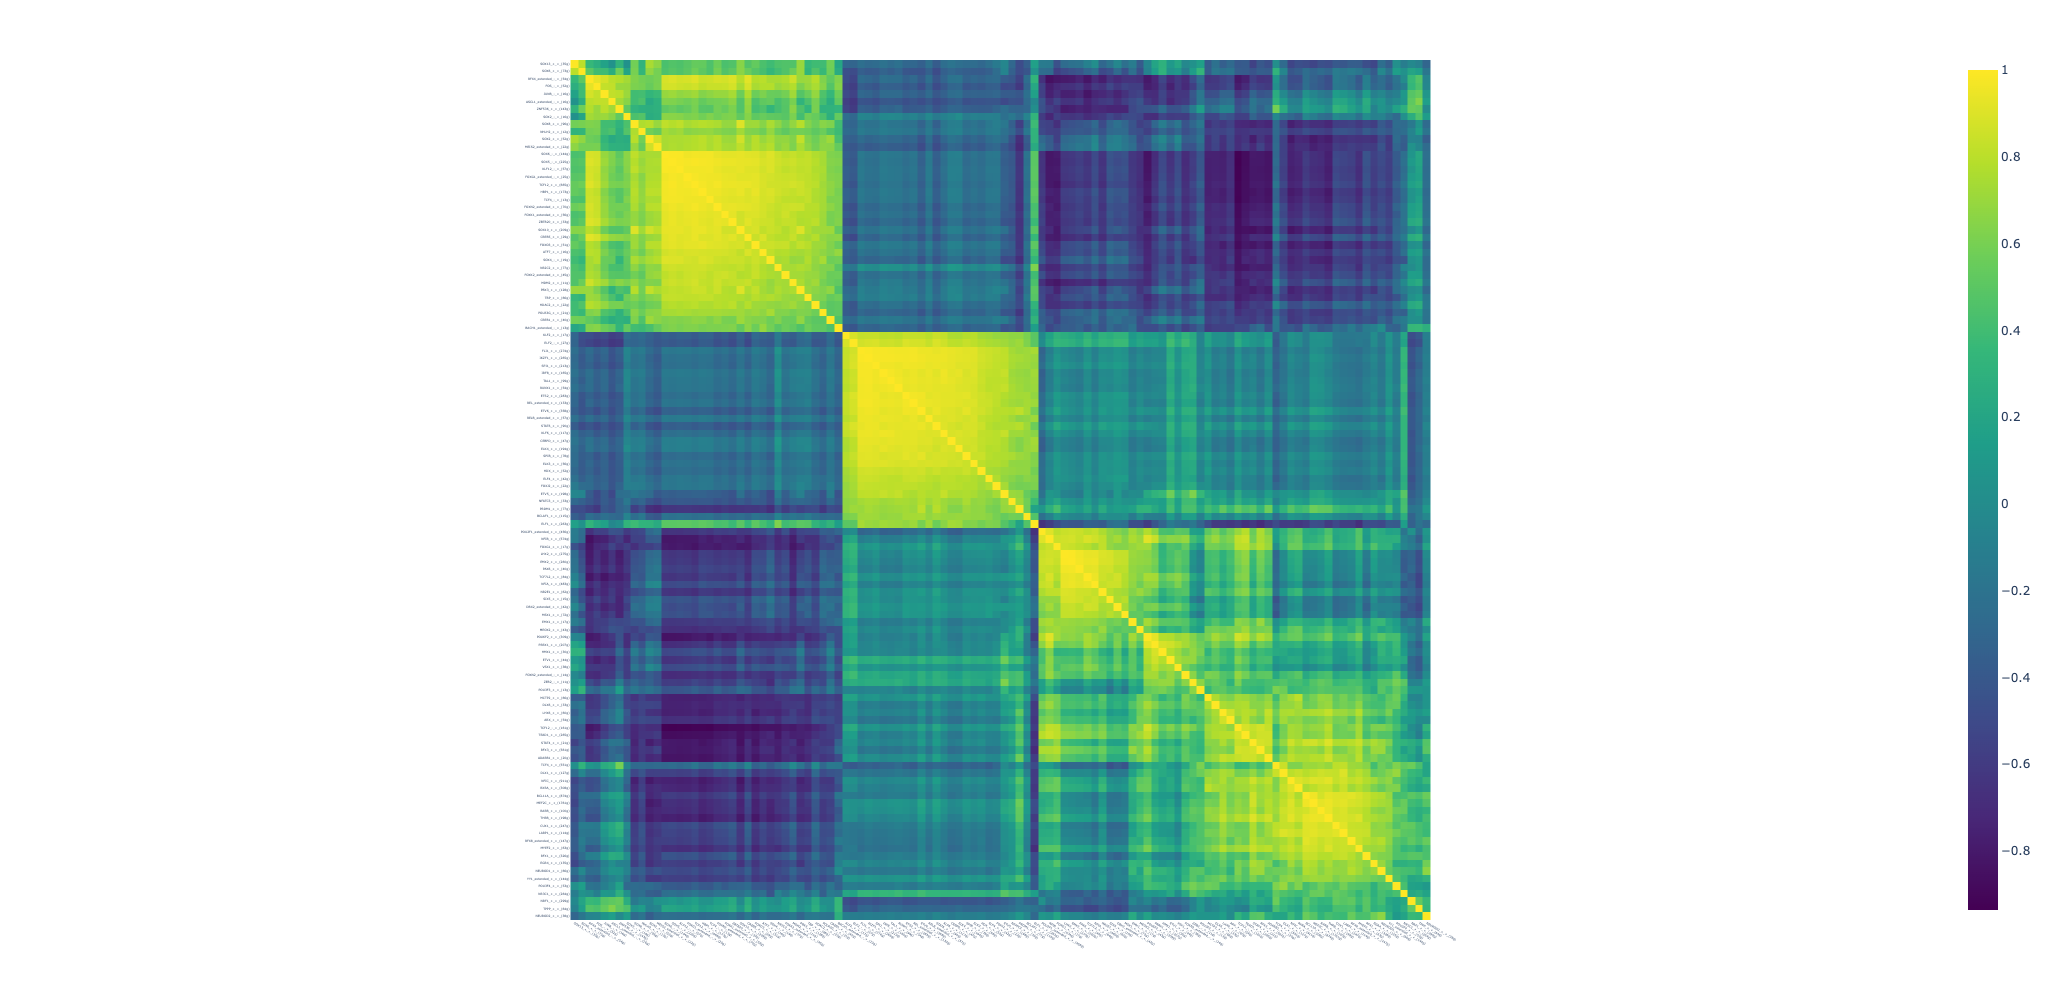

In [49]:
from scenicplus.plotting.correlation_plot import *
correlation_heatmap(scplus_obj,
                    auc_key = 'eRegulon_AUC', 
                    signature_keys = ['Gene_based'],
                    selected_regulons = scplus_obj.uns['selected_eRegulons']['Gene_based'],
                    fcluster_threshold = 0.1,
                    fontsize = 3)

We can also check the overlap between eRegulons:

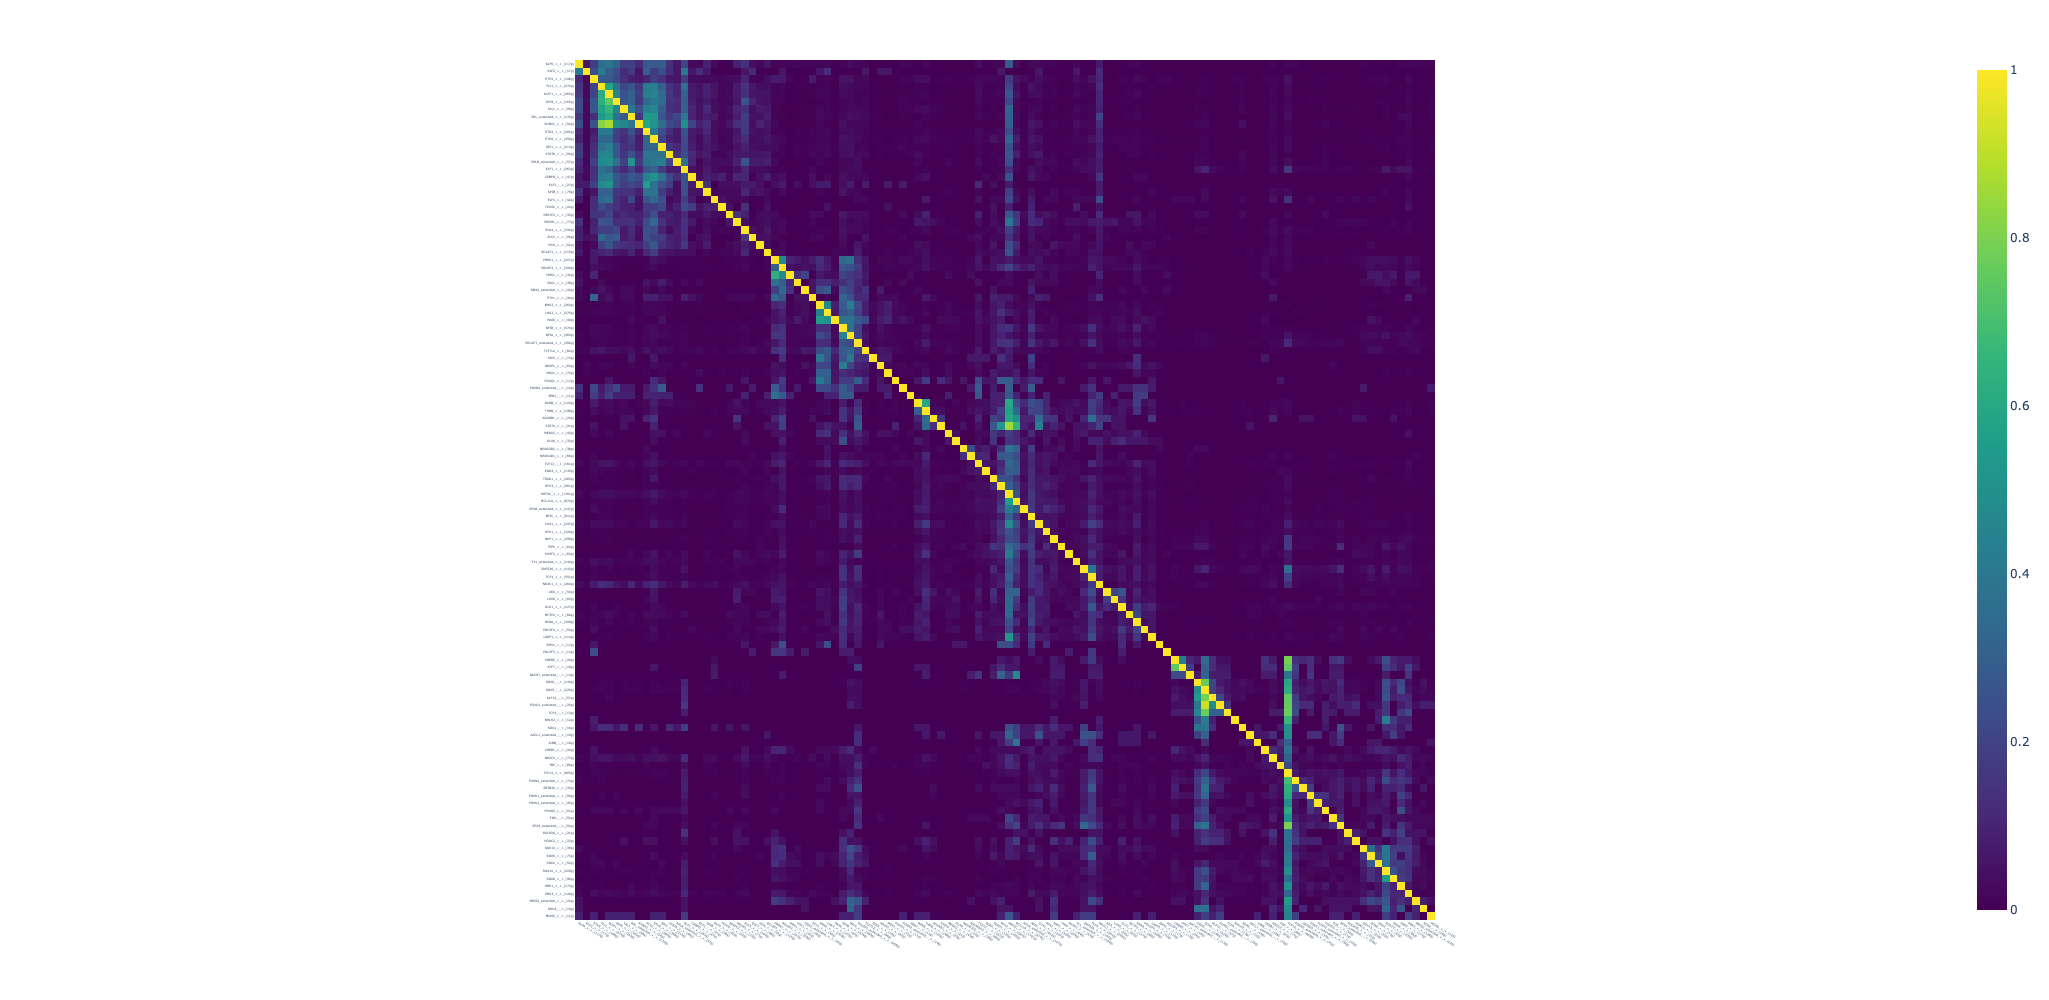

In [56]:
#from scenicplus.plotting.correlation_plot import *
jaccard_heatmap(scplus_obj,
                    gene_or_region_based = 'Gene_based',
                    signature_key = 'eRegulon_signatures',
                    selected_regulons = scplus_obj.uns['selected_eRegulons']['Gene_based'],
                    fcluster_threshold = 0.1,
                    fontsize = 3,
                    method='intersect')

We can also binarize the eRegulons as in SCENIC. This information will be used afterwards for generating the loom file.

In [21]:
binarize_AUC(scplus_obj, 
             auc_key='eRegulon_AUC',
             out_key='eRegulon_AUC_thresholds',
             signature_keys=['Gene_based', 'Region_based'],
             n_cpu=8)

In [22]:
import dill
with open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'wb') as f:
  dill.dump(scplus_obj, f)

### F. eGRN dimensionality reduction

We can also use the eRegulons for clustering and visualization. The combination of both gene and region based eRegulons results in a better clustering.

In [1]:
import dill
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'rb')
scplus_obj = dill.load(infile)
infile.close()

In [57]:
from scenicplus.dimensionality_reduction import *
run_eRegulons_umap(scplus_obj,
                   scale=True, signature_keys=['Gene_based', 'Region_based'], selected_regulons=scplus_obj.uns['selected_eRegulons']['Gene_based'])
run_eRegulons_tsne(scplus_obj,
                   scale=True, signature_keys=['Gene_based', 'Region_based'], selected_regulons=scplus_obj.uns['selected_eRegulons']['Gene_based'])

We can also compare with using the layers independently as well.

In [60]:
run_eRegulons_umap(scplus_obj,
                   scale=True, signature_keys=['Gene_based'],
                   reduction_name='eRegulons_UMAP_gb', selected_regulons=scplus_obj.uns['selected_eRegulons']['Gene_based'])
run_eRegulons_tsne(scplus_obj,
                   scale=True, signature_keys=['Gene_based'],
                   reduction_name='eRegulons_tSNE_gb', selected_regulons=scplus_obj.uns['selected_eRegulons']['Gene_based'])
run_eRegulons_umap(scplus_obj,
                   scale=True, signature_keys=['Region_based'],
                   reduction_name='eRegulons_UMAP_rb', selected_regulons=scplus_obj.uns['selected_eRegulons']['Region_based'])
run_eRegulons_tsne(scplus_obj,
                   scale=True, signature_keys=['Region_based'],
                   reduction_name='eRegulons_tSNE_rb', selected_regulons=scplus_obj.uns['selected_eRegulons']['Region_based'])

Let's take a look:

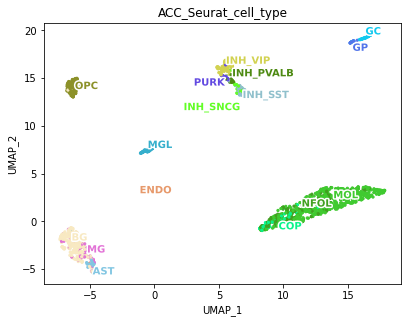

In [63]:
plot_metadata(scplus_obj,
                 reduction_name='eRegulons_UMAP_rb',
                 variables=['ACC_Seurat_cell_type'], 
                 num_columns=1,
                 text_size=10,
                 dot_size=5)

In addition, we can also use the eRegulon enrichment for clustering.

In [30]:
find_clusters(scplus_obj,
              signature_keys=['Gene_based', 'Region_based'],
              k = 10,
              res = [0.6, 1.2, 1.5], 
              prefix = 'SCENIC+_', 
              scale = True)

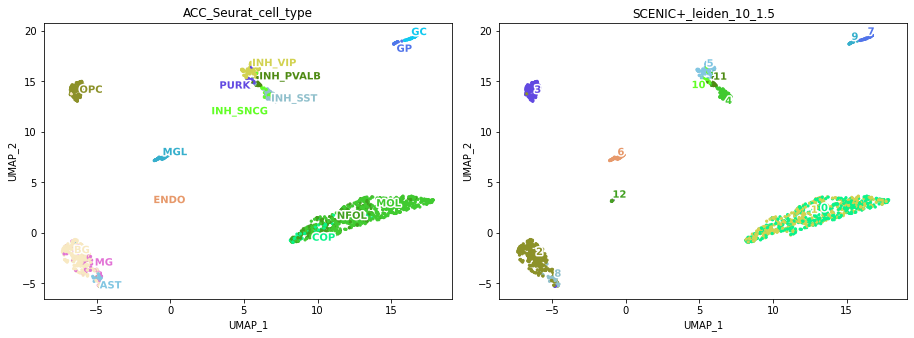

In [64]:
plot_metadata(scplus_obj,
                 reduction_name='eRegulons_UMAP_rb',
                 variables=['ACC_Seurat_cell_type', 'SCENIC+_leiden_10_1.5'], 
                 num_columns=2,
                 text_size=10,
                 dot_size=5)

We can also plot TF expression and eRegulon enrichment (based on target genes and regions, respectively).

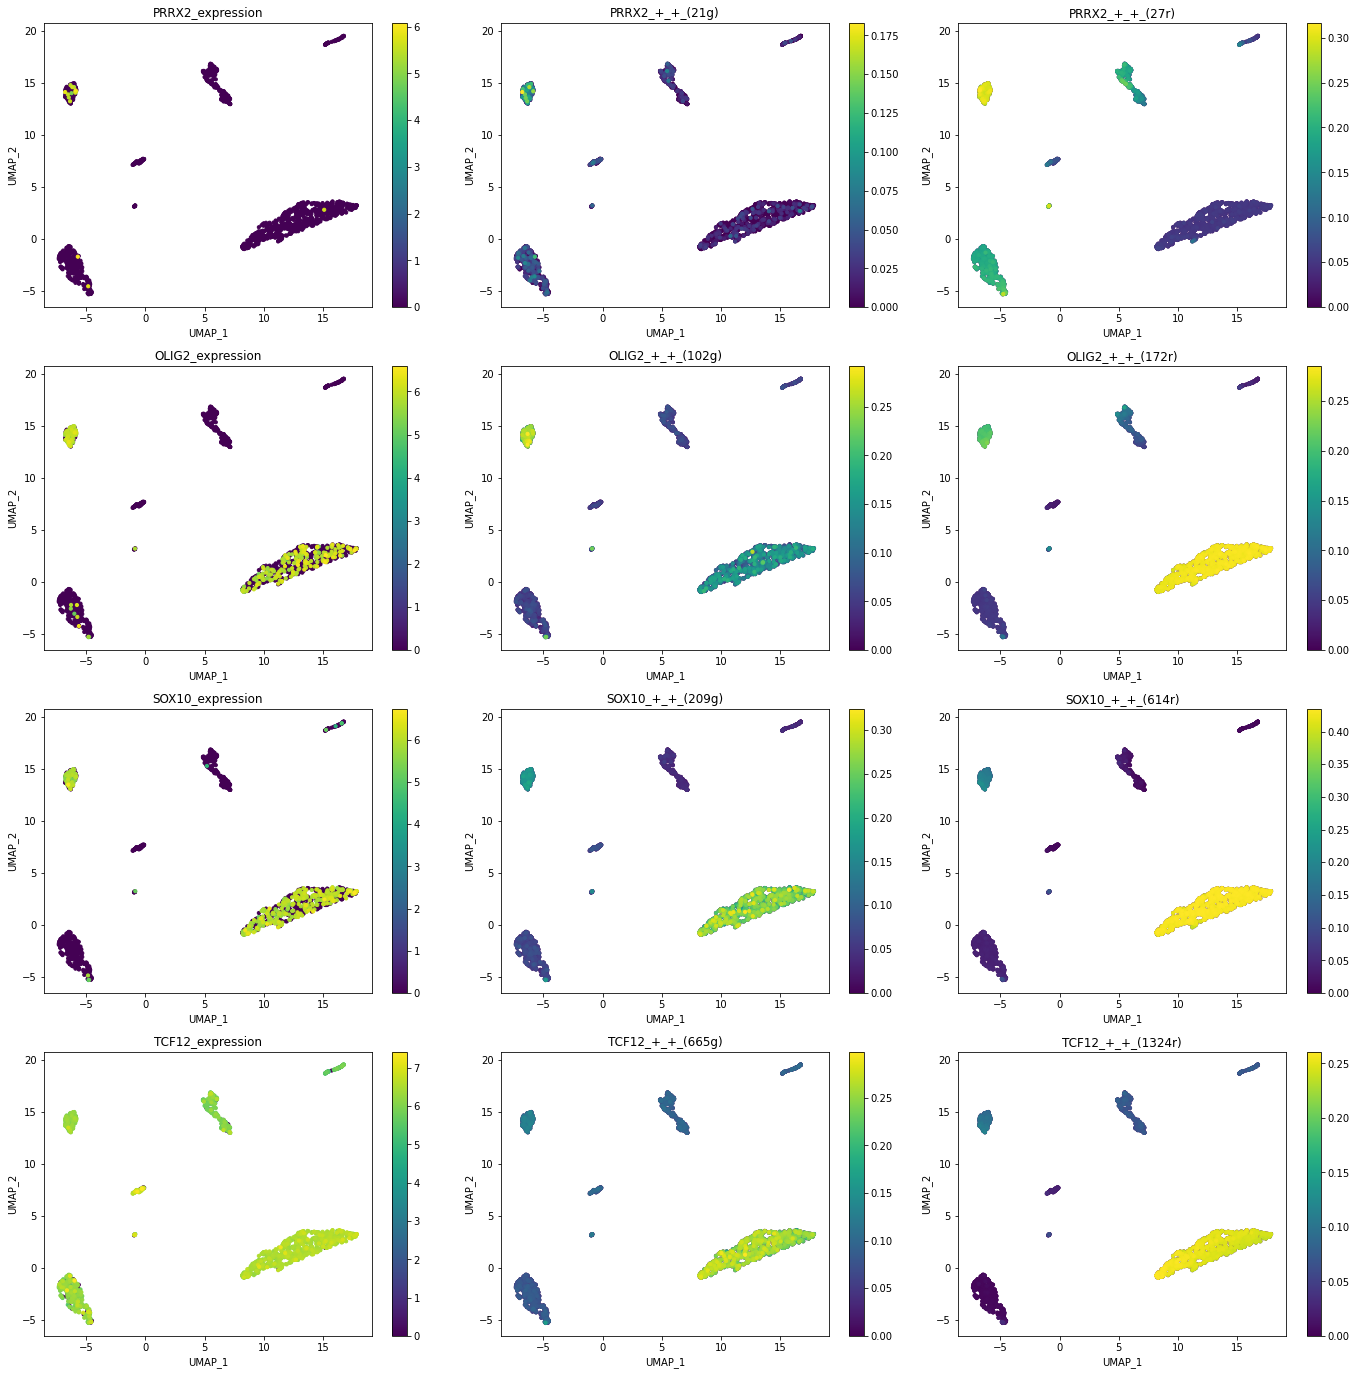

In [65]:
# For example, for some OL TFs
plot_eRegulon(scplus_obj,
              reduction_name='eRegulons_UMAP_rb',
              selected_regulons=['PRRX2_+_+','OLIG2_+_+', 'SOX10_+_+', 'TCF12_+_+'],
              normalize_tf_expression=True)

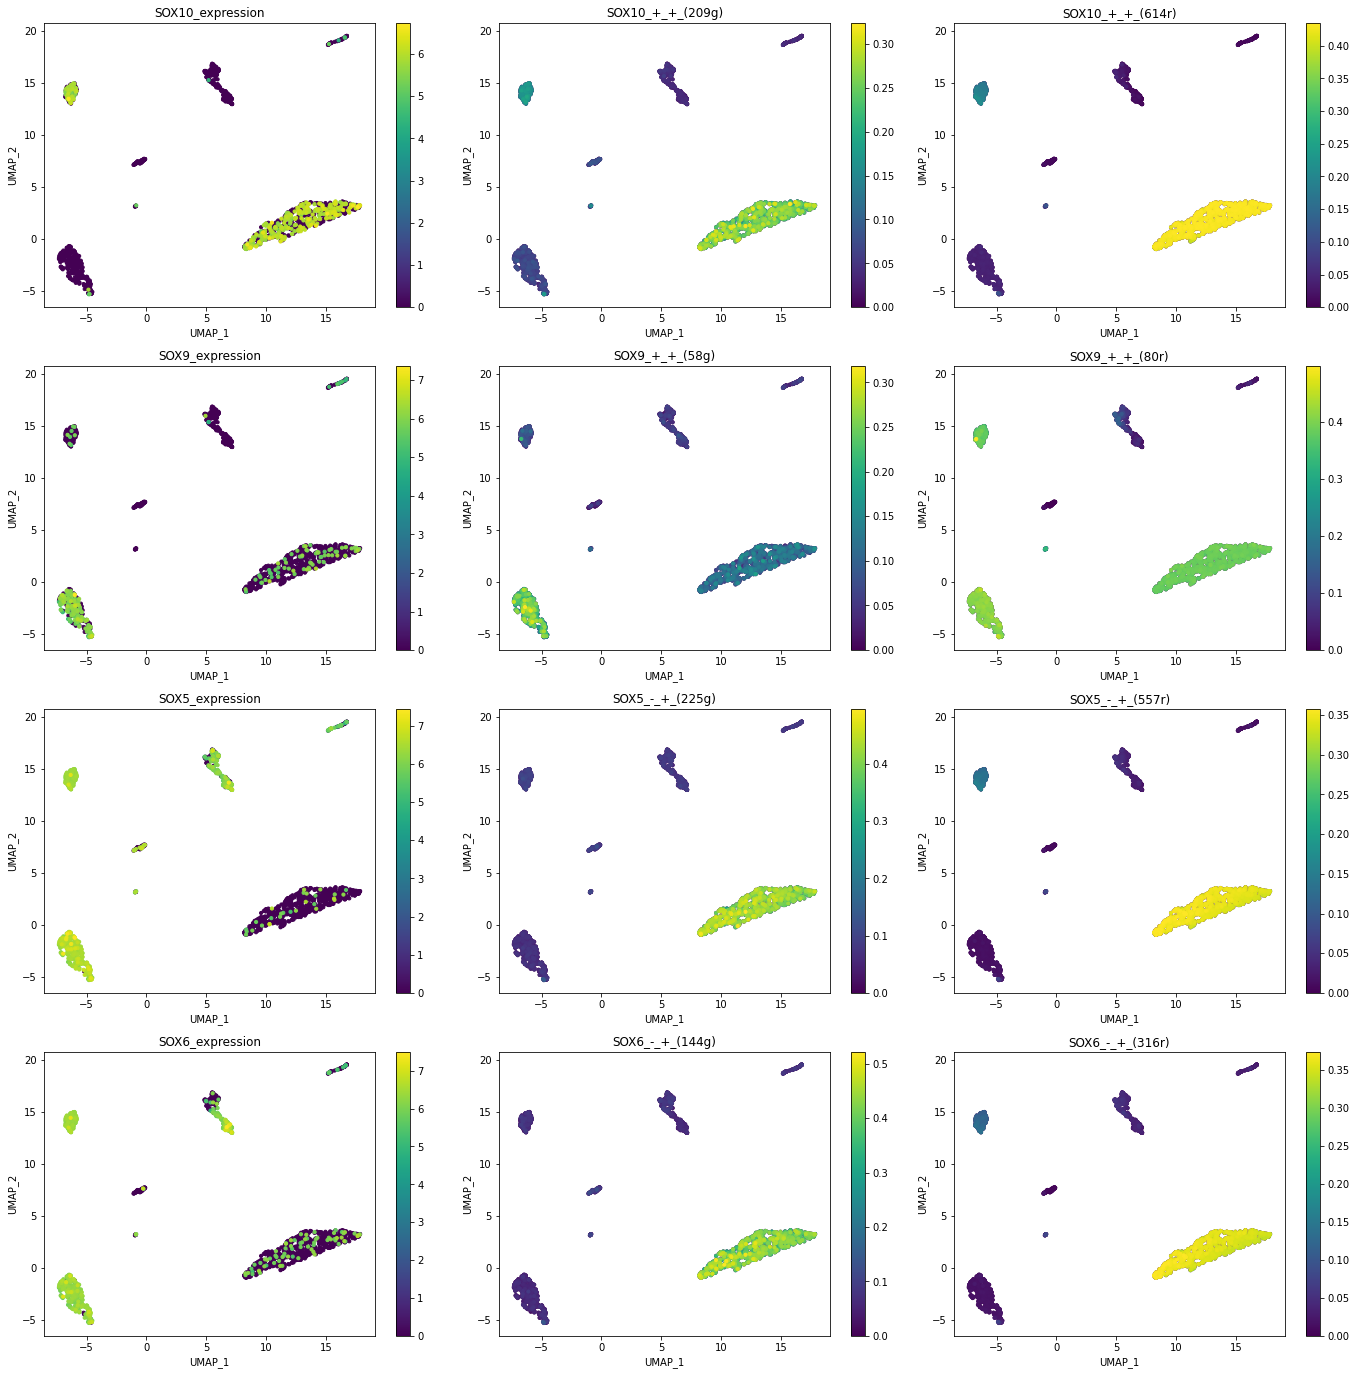

In [66]:
# To show between SOX10 and SOX5 (SOX5 targets and represses SOX10 regions)
plot_eRegulon(scplus_obj,
              reduction_name='eRegulons_UMAP_rb',
              selected_regulons=['SOX10_+_+', 'SOX9_+_+', 'SOX5_-_+', 'SOX6_-_+'],
              normalize_tf_expression=True)

In [ ]:
import dill
with open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'wb') as f:
  dill.dump(scplus_obj, f)

### G. eRegulon specificity scores

Recently, a novel method was developed and used to quantify the specificity of the regulons (from SCENIC) across different cell types (Suo et al., 2018). The RSS (Regulon Specificity Score) does not require binarization of a regulon’s enrichment score distribution and measures the distance between this distribution and the distribution of group annotations using the Jensen–Shannon Divergence. For a given group, the RSS for all predicted regulons is ranked from high to low, and highly group-specific regulons are spotted as outliers. This method can be applied to eRegulons as well.

In [1]:
import pickle
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'rb')
scplus_obj = pickle.load(infile)
infile.close()

/local_scratch/tmp-vsc31305/ipykernel_2530/1878697276.py:3: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  scplus_obj = pickle.load(infile)


In [4]:
from scenicplus.RSS import *
regulon_specificity_scores(scplus_obj, 
                         'ACC_Seurat_cell_type',
                         signature_keys=['Gene_based'],
                         selected_regulons=scplus_obj.uns['selected_eRegulons']['Gene_based'],
                         out_key_suffix='_gene_based',
                         scale=False)

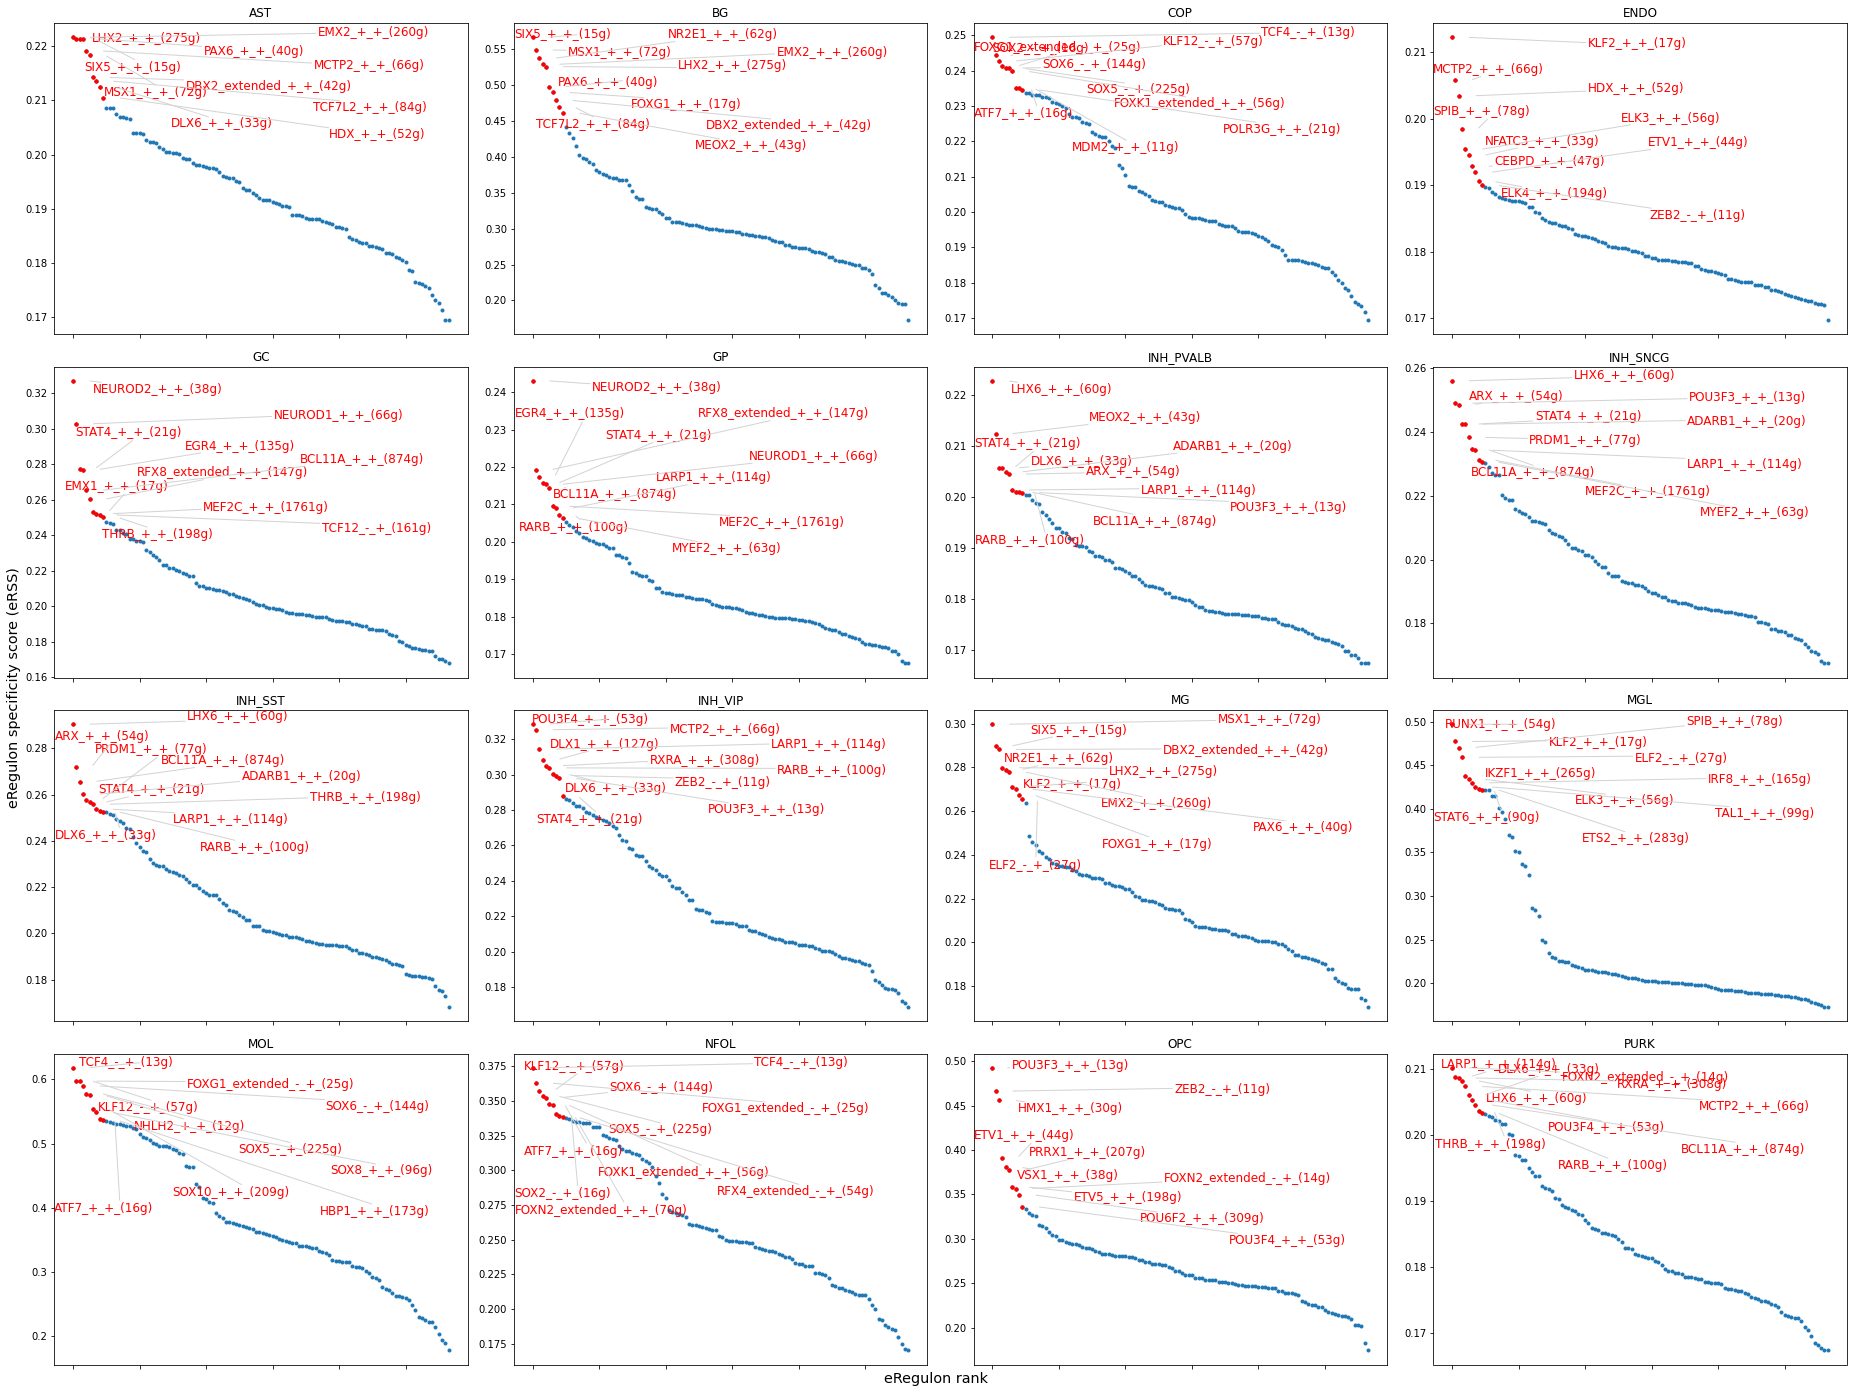

In [4]:
plot_rss(scplus_obj, 'ACC_Seurat_cell_type_gene_based', num_columns=4, top_n=10)

We can also plot an eGRN specificity dotplot using the RSS values:

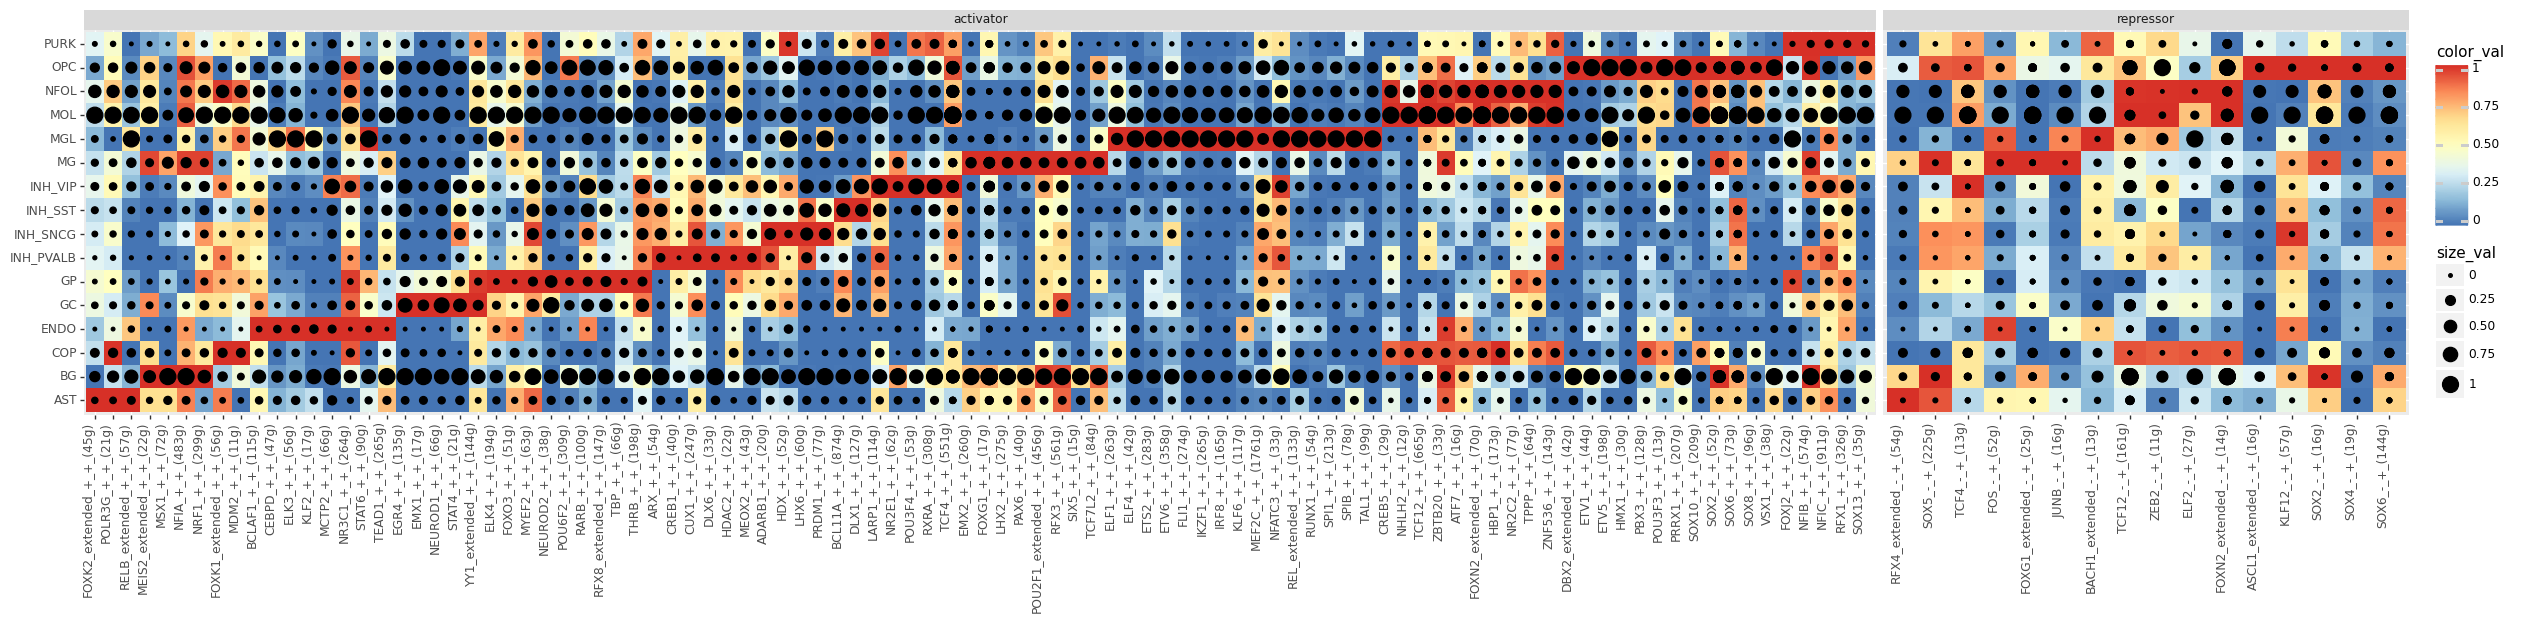

<ggplot: (2932560137801)>

In [14]:
#from scenicplus.plotting.dotplot import *
heatmap_dotplot(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['RSS']['ACC_Seurat_cell_type_gene_based'],
        color_matrix = scplus_obj.to_df('EXP'),
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'ACC_Seurat_cell_type',
        subset_eRegulons = scplus_obj.uns['selected_eRegulons']['Gene_based'],
        figsize = (30, 5),
        orientation = 'horizontal',
        split_repressor_activator=True)

In [ ]:
import dill
with open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'wb') as f:
  dill.dump(scplus_obj, f)

### H. Integrated multiome plot

We can also generate plots showing the chromatin profiles per group, region-to-gene relationships and TF and gene expression.

In [ ]:
import pickle
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'rb')
scplus_obj = pickle.load(infile)
infile.close()

In [16]:
# Generate interaction and annotation pyranges
import matplotlib.pyplot as plt
import os
from scenicplus.utils import get_interaction_pr
import pyranges as pr
bigwig_dir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/atac/pycistopic/consensus_peak_calling/seurat_pseudobulk_bw_files/'
bw_dict = {x.replace('.bw', ''): os.path.join(bigwig_dir, x) for x in os.listdir(bigwig_dir) if '.bw' in x}
pr_consensus_bed = pr.read_bed('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/atac/pycistopic/consensus_peak_calling/consensus_regions.bed')
pr_interact = get_interaction_pr(scplus_obj, 'hsapiens', 'hg38', inplace = False, subset_for_eRegulons_regions = True, eRegulons_key = 'eRegulons_importance')
gtf_file = "/lustre1/project/stg_00002/lcb/fderop/data/00000000_genomes/GRCh38_STAR_2.7.5_rna/genes.gtf"
pr_gtf = pr.read_gtf(gtf_file)

/opt/venv/lib/python3.8/site-packages/scenicplus/utils.py:652: RuntimeWarning: invalid value encountered in true_divide
/opt/venv/lib/python3.8/site-packages/scenicplus/utils.py:666: RuntimeWarning: invalid value encountered in true_divide


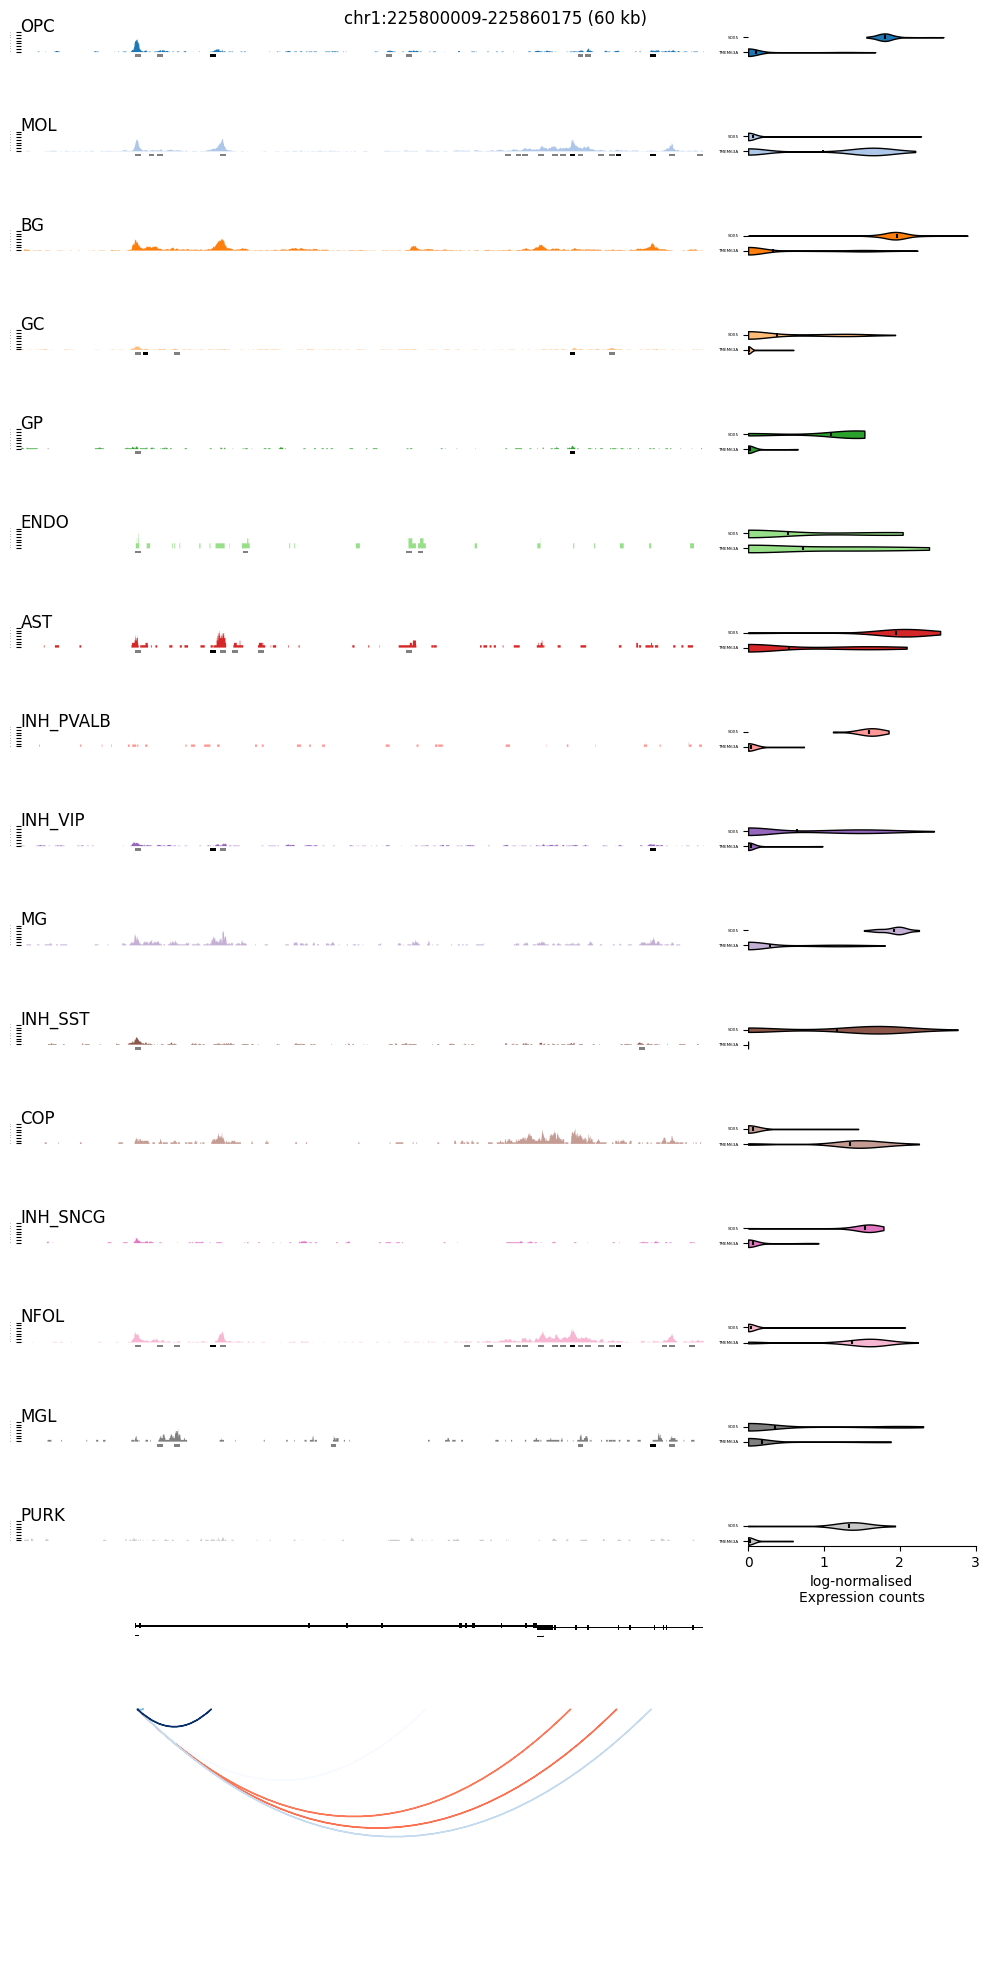

In [18]:
# Plot
from importlib import reload
from scenicplus.plotting.coverageplot import *
fig = coverage_plot(
        SCENICPLUS_obj = scplus_obj,
        bw_dict = bw_dict,
        region = 'chr1:225800009-225860175',
        figsize = (10,20),
       	pr_gtf = pr_gtf,
        color_dict = None,
        plot_order = None,
        pr_interact = pr_interact,
        genes_violin_plot = ['TMEM63A', 'SOX5'],
        meta_data_key = 'ACC_Seurat_cell_type',
        pr_consensus_bed = pr_consensus_bed,
        fontsize_dict={'bigwig_label': 12, 'gene_label': 0, 'violinplots_xlabel': 10, 'title': 12, 'bigwig_tick_label': 0, 'violinplots_ylabel': 3},
        height_ratios_dict = {'bigwig_violin': 1, 'genes': 0.5, 'arcs': 10, 'custom_ax': 5})
plt.tight_layout()

In [71]:
import dill
with open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'wb') as f:
  dill.dump(scplus_obj, f)

### I. Adding DEGs and DARs

We can as well include DEGs and DARs in the SCENIC+ object. Both DEGs and DARs can be computed; however, we recommend to compute DARs with pycisTopic as it provides a more efficient implementation for big data sets (and pycisTopic DARs are already used for motif enrichment). Note that results can be slightly different due to filtering.

In [1]:
import pickle
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'rb')
scplus_obj = pickle.load(infile)
infile.close()

In [6]:
#from pyscenic.diff_features import *
get_differential_features(scplus_obj, 'ACC_VSN_cell_type', use_hvg = True, contrast_type = ['DARs', 'DEGs'])
get_differential_features(scplus_obj, 'ACC_Seurat_cell_type', use_hvg = True, contrast_type = ['DARs', 'DEGs'])

2022-01-05 19:49:40,968 SCENIC+      INFO     Calculating DARs for variable ACC_VSN_cell_type
2022-01-05 19:50:13,849 SCENIC+      INFO     There are 93456 variable features


/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'GEX_VSN_cell_type' as categorical
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, copying.
... storing 'GEX_VSN_leiden_res0.3' as catego

2022-01-05 19:51:25,668 SCENIC+      INFO     Finished calculating DARs for variable ACC_VSN_cell_type
2022-01-05 19:51:25,671 SCENIC+      INFO     Calculating DEGs for variable ACC_VSN_cell_type
2022-01-05 19:51:31,555 SCENIC+      INFO     There are 4134 variable features


/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'GEX_VSN_cell_type' as categorical
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, copying.
... storing 'GEX_VSN_leiden_res0.3' as catego

2022-01-05 19:51:34,598 SCENIC+      INFO     Finished calculating DEGs for variable ACC_VSN_cell_type
2022-01-05 19:51:34,600 SCENIC+      INFO     Calculating DARs for variable ACC_Seurat_cell_type
2022-01-05 19:52:08,736 SCENIC+      INFO     There are 101191 variable features


/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'GEX_VSN_cell_type' as categorical
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, copying.
... storing 'GEX_VSN_leiden_res0.3' as catego

2022-01-05 19:53:36,129 SCENIC+      INFO     Finished calculating DARs for variable ACC_Seurat_cell_type
2022-01-05 19:53:36,132 SCENIC+      INFO     Calculating DEGs for variable ACC_Seurat_cell_type
2022-01-05 19:53:37,694 SCENIC+      INFO     There are 4524 variable features


/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'GEX_VSN_cell_type' as categorical
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs` of view, copying.
... storing 'GEX_VSN_leiden_res0.3' as catego

2022-01-05 19:53:41,195 SCENIC+      INFO     Finished calculating DEGs for variable ACC_Seurat_cell_type


In [18]:
import dill
with open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'wb') as f:
  dill.dump(scplus_obj, f)

### J. Export to loom

You can also export the data to a loom file (gene based and region based, respectively). These loom files can be queried at https://scope.aertslab.org/.

In [1]:
import pickle
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'rb')
scplus_obj = pickle.load(infile)
infile.close()

In [3]:
from scenicplus.loom import *
export_to_loom(scplus_obj, 
               signature_key = 'Gene_based',
               tree_structure = ('10x_multiome_brain', 'SCENIC+'),
               title = 'Tutorial - Gene based eGRN',
               nomenclature = "hg38",
               out_fname='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/HC_gene_based.loom')

2022-01-06 17:37:54,023 SCENIC+      INFO     Formatting data
2022-01-06 17:38:01,938 SCENIC+      INFO     Creating minimal loom
2022-01-06 17:38:13,182 SCENIC+      INFO     Adding annotations
2022-01-06 17:38:16,020 SCENIC+      INFO     Adding clusterings
2022-01-06 17:38:16,375 SCENIC+      INFO     Adding markers
2022-01-06 17:38:17,649 SCENIC+      INFO     Exporting


/opt/venv/lib/python3.8/site-packages/loomxpy/loomxpy.py:459: FutureWarning: The default value of regex will change from True to False in a future version.
  regulons.columns = regulons.columns.str.replace("_?\\(", "_(")
/opt/venv/lib/python3.8/site-packages/loomxpy/loomxpy.py:437: FutureWarning: The default value of regex will change from True to False in a future version.
  regulons.columns = regulons.columns.str.replace("_?\\(", "_(")


In [5]:
export_to_loom(scplus_obj, 
               signature_key = 'Region_based',
               tree_structure = ('10x_multiome_brain', 'SCENIC+'),
               title = 'Tutorial - Gene based eGRN',
               nomenclature = "hg38",
               out_fname='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/HC_region_based.loom')

2022-01-06 17:38:44,989 SCENIC+      INFO     Formatting data
2022-01-06 17:38:59,521 SCENIC+      INFO     Creating minimal loom
2022-01-06 17:43:59,040 SCENIC+      INFO     Adding annotations
2022-01-06 17:44:49,492 SCENIC+      INFO     Adding clusterings
2022-01-06 17:44:49,952 SCENIC+      INFO     Adding markers
2022-01-06 17:45:17,312 SCENIC+      INFO     Exporting


### K. cisTarget on eRegulons

You can confirm the quality of the eRegulons by running cisTarget on them.

In [12]:
import pyranges as pr
from pycistarget.utils import *
selected_regulons = ['SOX10_+_+', 'OLIG2_+_+']
selected_regulons = [list(filter(lambda x: x.startswith(y), scplus_obj.uns['eRegulon_signatures']['Region_based'].keys()))[0] for y in selected_regulons]
region_sets = {key: pr.PyRanges(region_names_to_coordinates(scplus_obj.uns['eRegulon_signatures']['Region_based'][key])) for key in selected_regulons}
selected_regulons

['SOX10_+_+_(614r)', 'OLIG2_+_+_(172r)']

In [13]:
# Load cistarget functions
from pycistarget.motif_enrichment_cistarget import *
# Preload db, you can also just provide the path to the db. Preloading the database is useful if you want to test different parameters. 
# This will take some time depending on the size of your database
db = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/atac/pycistarget/dbs/human_brain.regions_vs_motifs.rankings.feather'
ctx_db = cisTargetDatabase(db, region_sets)   
# Remove dbcorr motifs
ctx_db.db_rankings = ctx_db.db_rankings[~ctx_db.db_rankings.index.str.contains("dbcorr")]
# Run
cistarget_dict = run_cistarget(ctx_db = ctx_db,
                               region_sets = region_sets,
                               specie = 'homo_sapiens',
                               annotation_version = 'v9nr_clust',
                               path_to_motif_annotations = '/staging/leuven/stg_00002/lcb/cbravo/motif_clustering/RNA_harmony_snn_res_5_clusters/motif_collection_combined_motifs_stamp_and_singlets/hs_annotation.tsv',
                               auc_threshold = 0.005,
                               nes_threshold = 3.0,
                               rank_threshold = 0.05,
                               annotation = ['Direct_annot', 'Orthology_annot'],
                               n_cpu = 1,
                               _temp_dir='/scratch/leuven/313/vsc31305/ray_spill')

2022-01-06 17:53:14,926 cisTarget    INFO     Reading cisTarget database
2022-01-06 17:54:11,634 cisTarget    INFO     Running cisTarget for SOX10_+_+_(614r) which has 614 regions
2022-01-06 17:54:38,745 cisTarget    INFO     Annotating motifs for SOX10_+_+_(614r)
2022-01-06 17:54:40,659 cisTarget    INFO     Getting cistromes for SOX10_+_+_(614r)
2022-01-06 17:54:40,948 cisTarget    INFO     Running cisTarget for OLIG2_+_+_(172r) which has 172 regions
2022-01-06 17:54:46,872 cisTarget    INFO     Annotating motifs for OLIG2_+_+_(172r)
2022-01-06 17:54:49,364 cisTarget    INFO     Getting cistromes for OLIG2_+_+_(172r)
2022-01-06 17:54:49,890 cisTarget    INFO     Done!


In [16]:
cistarget_results(cistarget_dict, name='SOX10_+_+_(614r)')

### L. Plotting networks

We can also plot networks using networkx and pyvis (for interactive networks). For example, here we are going to make a small network with 10 oligodendroycte genes controlled by SOX10, OLIG2 and TCF12.

In [1]:
from scenicplus.networks import *
import pickle
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'rb')
scplus_obj = pickle.load(infile)
infile.close()

The following function will generate a dictionary with node and edge features. It is possible to add additional columns to these data frames (e.g. enrichment of a motif in a region), to use it afterwards as variable to control the features of nodes and edges when plotting. Alternatively, we can also calculate logFC between given groups to use as variable as well.

In [20]:
from scenicplus.networks import *
import networkx as nx
subset_genes = ['PLP1', 'SOX8', 'EPN1', 'OLIG1', 'MOG', 'OLIG2', 'SOX10', 'PLLP', 'PBX3', 'LRRN1', 'UBL8']
nx_tables = create_nx_tables(scplus_obj,
                    eRegulon_metadata_key = 'eRegulon_metadata',
                    subset_eRegulons = ['SOX10', 'OLIG2', 'TCF12'],
                    subset_regions = None,
                    subset_genes = subset_genes,
                    add_differential_gene_expression = True,
                    add_differential_region_accessibility = True,
                    differential_variable = ['ACC_Seurat_cell_type', 'ACC_VSN_cell_type'])

/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializ

We can now generate the network. To control features (e.g. size, color and transparency of nodes; width, color, transparency of edges, size and color of labels), we can pass dictionaries. Each dictitonary will be named by the slot on the tables dictionary and will include the name of the variable to use ('variable'; if you want to use a fixed value use 'fixed_VARNAME'), and scales (a dictionary if a discrete variable is used, a colormap if a continuous map is used, with minimum and maximum values). Two layouts are available: 'concentrical' and Kamada Kawai.

In [21]:
from scenicplus.networks import *
G_c, pos_c, edge_tables_c, node_tables_c = create_nx_graph(nx_tables, 
                   use_edge_tables = ['TF2R','R2G'],
                   color_edge_by = {'TF2R': {'variable' : 'TF', 'category_color' : {'SOX10': 'Orange', 'OLIG2': 'Purple', 'TCF12': 'Red'}},
                                    'R2G': {'variable' : 'R2G_rho', 'continuous_color' : 'viridis', 'v_min': -1, 'v_max': 1}},
                   transparency_edge_by =  {'R2G': {'variable' : 'R2G_importance', 'min_alpha': 0.1, 'v_min': 0}},
                   width_edge_by = {'R2G': {'variable' : 'R2G_importance', 'max_size' :  1.5, 'min_size' : 1}},
                   color_node_by = {'TF': {'variable': 'TF', 'category_color' : {'SOX10': 'Orange', 'OLIG2': 'Purple',  'TCF12': 'Red'}},
                                    'Gene': {'variable': 'ACC_Seurat_cell_type_Log2FC_MOL', 'continuous_color' : 'bwr'},
                                    'Region': {'variable': 'ACC_Seurat_cell_type_Log2FC_MOL', 'continuous_color' : 'viridis'}},
                   transparency_node_by =  {'Region': {'variable' : 'ACC_Seurat_cell_type_Log2FC_MOL', 'min_alpha': 0.1},
                                    'Gene': {'variable' : 'ACC_Seurat_cell_type_Log2FC_MOL', 'min_alpha': 0.1}},
                   size_node_by = {'TF': {'variable': 'fixed_size', 'fixed_size': 30},
                                    'Gene': {'variable': 'fixed_size', 'fixed_size': 15},
                                    'Region': {'variable': 'fixed_size', 'fixed_size': 10}},
                   shape_node_by = {'TF': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Gene': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Region': {'variable': 'fixed_shape', 'fixed_shape': 'diamond'}},
                   label_size_by = {'TF': {'variable': 'fixed_label_size', 'fixed_label_size': 20.0},
                                    'Gene': {'variable': 'fixed_label_size', 'fixed_label_size': 10.0},
                                    'Region': {'variable': 'fixed_label_size', 'fixed_label_size': 0.0}},
                   layout='concentrical_layout',
                   scale_position_by=250)

It is possible to plot static networks with networkx:

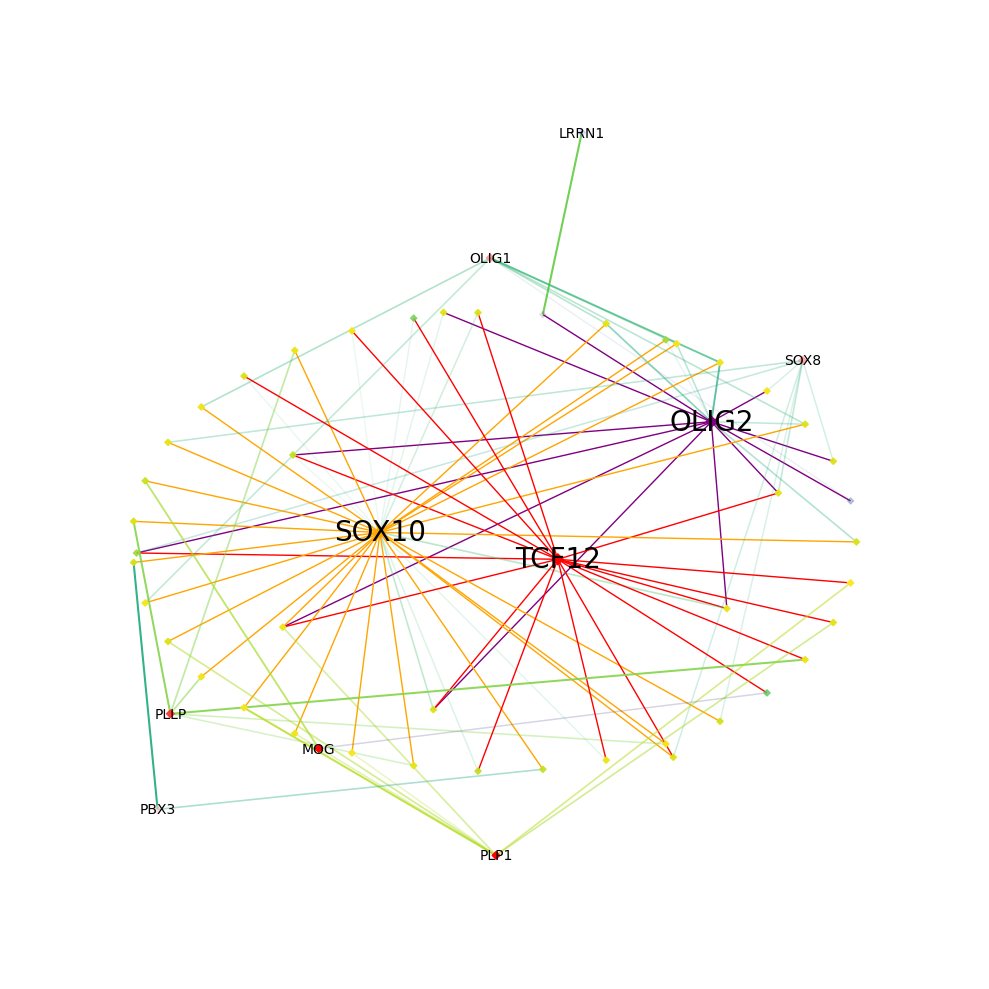

In [28]:
# To draw with networkx
plt.figure(figsize=(10,10))
plot_networkx(G_c, pos_c)

We can also show the results using the Kamada Kawai algorithm:

In [24]:
G_kk, pos_kk, edge_tables_kk, node_tables_kk = create_nx_graph(nx_tables, 
                   use_edge_tables = ['TF2R','R2G'],
                   color_edge_by = {'TF2R': {'variable' : 'TF', 'category_color' : {'SOX10': 'Orange', 'OLIG2': 'Purple', 'TCF12': 'Red'}},
                                    'R2G': {'variable' : 'R2G_rho', 'continuous_color' : 'viridis', 'v_min': -1, 'v_max': 1}},
                   transparency_edge_by =  {'R2G': {'variable' : 'R2G_importance', 'min_alpha': 0.1, 'v_min': 0}},
                   width_edge_by = {'R2G': {'variable' : 'R2G_importance', 'max_size' :  1.5, 'min_size' : 1}},
                   color_node_by = {'TF': {'variable': 'TF', 'category_color' : {'SOX10': 'Orange', 'OLIG2': 'Purple',  'TCF12': 'Red'}},
                                    'Gene': {'variable': 'ACC_Seurat_cell_type_Log2FC_MOL', 'continuous_color' : 'bwr'},
                                    'Region': {'variable': 'ACC_Seurat_cell_type_Log2FC_MOL', 'continuous_color' : 'viridis'}},
                   transparency_node_by =  {'Region': {'variable' : 'ACC_Seurat_cell_type_Log2FC_MOL', 'min_alpha': 0.1},
                                    'Gene': {'variable' : 'ACC_Seurat_cell_type_Log2FC_MOL', 'min_alpha': 0.1}},
                   size_node_by = {'TF': {'variable': 'fixed_size', 'fixed_size': 30},
                                    'Gene': {'variable': 'fixed_size', 'fixed_size': 15},
                                    'Region': {'variable': 'fixed_size', 'fixed_size': 10}},
                   shape_node_by = {'TF': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Gene': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Region': {'variable': 'fixed_shape', 'fixed_shape': 'diamond'}},
                   label_size_by = {'TF': {'variable': 'fixed_label_size', 'fixed_label_size': 20.0},
                                    'Gene': {'variable': 'fixed_label_size', 'fixed_label_size': 10.0},
                                    'Region': {'variable': 'fixed_label_size', 'fixed_label_size': 0.0}},
                   layout='kamada_kawai_layout',
                   scale_position_by = 500)

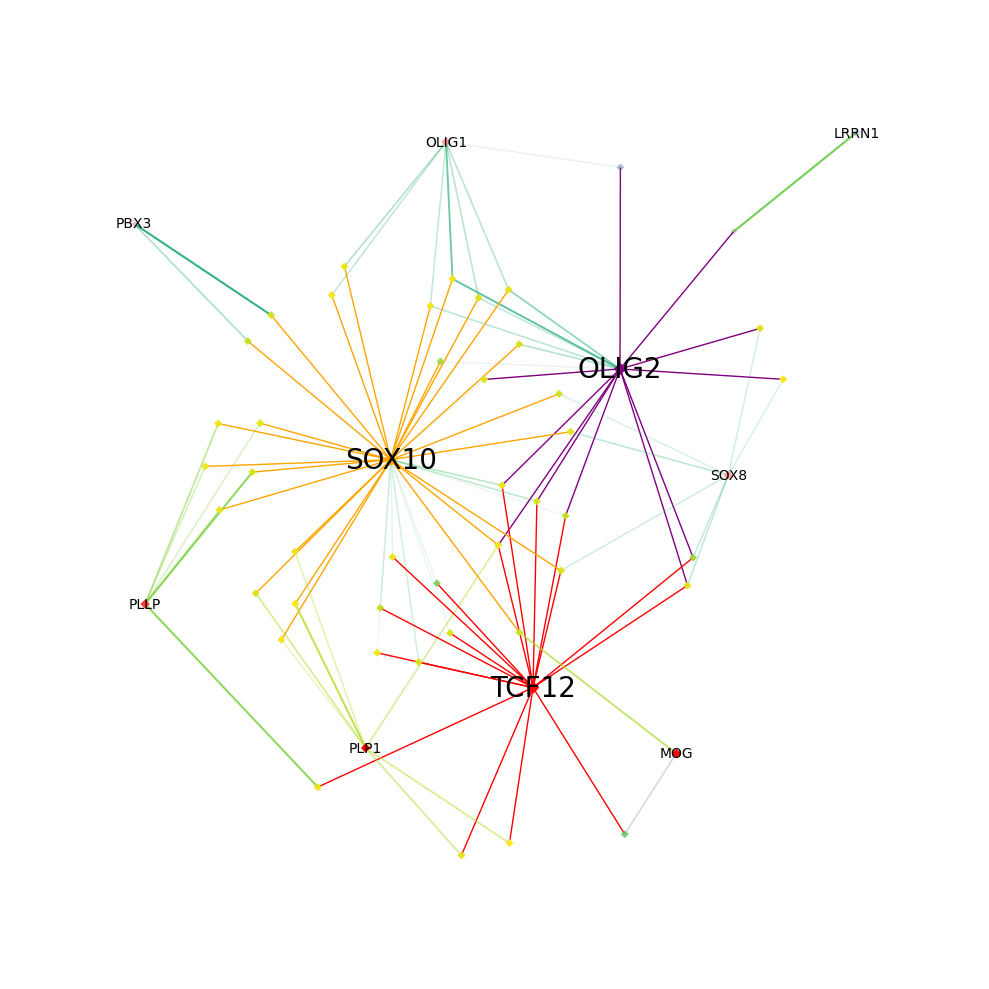

In [25]:
plt.figure(figsize=(10,10))
plot_networkx(G_kk, pos_kk)

To export the network to CytoScape you can use the function below. Once you load the network in CytoScape, remember to use the SCENIC+ style (available in the SCENIC+ github).

In [27]:
export_to_cytoscape(G_kk, pos_kk,
                    '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/cytoscape/final_version_kk.cyjs', 
                    pos_scaling_factor=200, size_scaling_factor=1)

### M. Exporting to UCSC

While pseudobulk profiles can be generated with pycisTopic; we can export region eRegulons and region-to-gene links to visualize in UCSC.

In [11]:
import pickle
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/scplus_obj.pkl', 'rb')
scplus_obj = pickle.load(infile)
infile.close()

In [12]:
from scenicplus.enhancer_to_gene import export_to_UCSC_interact
r2g_data = export_to_UCSC_interact(scplus_obj,
                            'hsapiens',
                            '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/human_cerebellum_r2g.rho.bed',
                            path_bedToBigBed='/staging/leuven/stg_00002/lcb/sdewin/PhD/De_Winter_hNTorg/COMBINED_ANALYSIS/r2g/',
                            bigbed_outfile='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/human_cerebellum_r2g.rho.interact.bb',
                            region_to_gene_key='region_to_gene',
                            pbm_host='http://www.ensembl.org',
                            assembly='hg38',
                            ucsc_track_name='HC_R2G',
                            ucsc_description='Region_to_gene in the human cerebellum 10X data set',
                            cmap_neg='Reds',
                            cmap_pos='Greens',
                            key_for_color='rho',
                            vmin=-1,
                            vmax=1,
                            scale_by_gene=False,
                            subset_for_eRegulons_regions=True,
                            eRegulons_key='eRegulons_importance')

2022-01-11 20:02:09,140 R2G          INFO     Downloading gene annotation from biomart, using dataset: hsapiens_gene_ensembl
2022-01-11 20:02:09,742 R2G          INFO     Formatting data ...


/opt/venv/lib/python3.8/site-packages/scenicplus/enhancer_to_gene.py:750: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  annot = dataset.query(attributes=['chromosome_name', 'start_position', 'end_position',


2022-01-11 20:02:30,715 R2G          INFO     Writing data to: /staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/human_cerebellum_r2g.rho.bed
2022-01-11 20:02:31,849 R2G          INFO     Writing data to: /staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/human_cerebellum_r2g.rho.interact.bb


In [13]:
from scenicplus.utils import export_eRegulons
regions = export_eRegulons(scplus_obj,
                '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/human_cerebellum_eRegulons.bed',
                'hg38',
                bigbed_outfile = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/scenicplus/human_cerebellum_eRegulons.bb',
                eRegulon_metadata_key = 'eRegulon_metadata',
                eRegulon_signature_key = 'eRegulon_signatures',
                path_bedToBigBed='/data/leuven/software/biomed/haswell_centos7/2018a/software/Kent_tools/20190730-linux.x86_64/bin/')